In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
% matplotlib inline

# get input datas
def get_stock_data(symbol):
    df = pd.read_csv('yahoo/20160922/{}.csv'.format(symbol), index_col='Date', parse_dates=True,
                     usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'],
                     na_values=['nan'])
    df.dropna()
    return df

def draw_rolling_statistics(df, symbol, window):
    rolling_mean = df[symbol].rolling(window=window).mean()
    rolling_std = df[symbol].rolling(window=window).std()
    bollinger_band_upper = rolling_mean + 2 * rolling_std
    bollinger_band_lower = rolling_mean - 2 * rolling_std
    plot = df[symbol].plot(title='{} rolling mean'.format(symbol), label='price')
    rolling_mean.plot(label='rolling mean', ax=plot)
    bollinger_band_upper.plot(label='upper band', ax=plot)
    bollinger_band_lower.plot(label='lower band', ax=plot)
    plot.set_xlabel("Date")
    plot.set_ylabel("Price")
    plot.legend(loc='upper left')
    plt.show()

def draw_scatter_plot(daily_returns, x_symbol, y_symbol):
    daily_returns.plot(kind='scatter', x=x_symbol, y=y_symbol, title='{} vs {} Daily return Scatter plot'.format(x_symbol, y_symbol))
    beta, alpha=np.polyfit(daily_returns[x_symbol], daily_returns[y_symbol], 1)
    plt.plot(daily_returns[x_symbol], beta * daily_returns[x_symbol] + alpha, '-', color='r')
    plt.show()

def draw_value_of_future_dollor(label, future_value, IR):
    time_years = np.linspace(0, 10, 21)
    present_value = future_value / (1 + IR) ** time_years
    plt.plot(time_years, present_value, linewidth=2.0, label=label)
    
def calculate_daily_returns(df):
    daily_returns=df.copy()
    daily_returns=(daily_returns/daily_returns.shift(1))-1
    return daily_returns[1:]

def calculate_cumulative_returns(df):
    return (df/df.ix[0]) - 1

def calculate_porfolio_value(df, start_val, symbols, allocs):
    portfolio_close_df=df[symbols]
    normalized_df=portfolio_close_df/portfolio_close_df.ix[0,:]
    alloced_df=normalized_df * allocs
    position_vals_df=alloced_df * start_val
    portfolio_val_df=position_vals_df.sum(axis=1)
    return portfolio_val_df

def calculate_intrinsic_value(dividends_per_year, discount_rate):
    return dividends_per_year / discount_rate

def calculate_book_value(total_assets, intangible_assets, liabilities):
    return total_assets - intangible_assets - liabilities

def calculate_market_capitalization(number_of_shares, price_per_share):
    return number_of_shares * price_per_share

def calculate_capm_stock_return(market_return, stock_alpha, stock_beta):
    if stock_alpha < 0:
        return -(stock_beta * market_return + stock_alpha)
    return stock_beta * market_return + stock_alpha

def calculate_capm_portfolio_return(market_return, allocs, alphas, betas):
    return (allocs * betas * market_return + allocs * alphas).sum()

def error(allocs, betas):
    for alloc in allocs:
        if alloc >= 1:
            return 1000000

    err = abs(allocs[0] * betas[0] + allocs[1] * betas[1]) + abs(sum(abs(allocs)) - 1)
    return err

def fit_line(betas, error_func):
    allocs = np.float32([.9, .1])
    result = spo.minimize(error_func, allocs, args=(betas,), method="SLSQP", options={'disp': True, 'maxiter': 1000})
    return result.x

def calculate_capm_weights_from_betas(betas):
    l_fit = fit_line(betas, error)
    print "Fitted line:C0={}, C1={}".format(l_fit[0], l_fit[1])

def calculate_momentum(df, n):
    df=df/df.shift(n)
    return df[n:] - 1

def calculate_sma(df, n):
    return (df/df.rolling(window=n,center=False).mean())[n:] - 1

def calculate_bb(df, n):
    std=(df.rolling(window=n,center=False).std())[n:]
    ma=(df.rolling(window=n,center=False).mean())[n:]
    upper_bound=ma+2*std
    lower_bound=ma-2*std
    return upper_bound, lower_bound

def normalize(df):
    return (df - df.mean())/df.std()

In [2]:
stocks = {}
symbols = ['GOOGL', 'AAPL', 'sp500']
for symbol in symbols:
    stocks[symbol] = get_stock_data(symbol)
    

start_date = '2016-01-01'
end_date = '2016-05-31'
dates = pd.date_range(start_date, end_date)

adj_close_df = pd.DataFrame(index=dates)
for stock_name in stocks:
    stock = stocks[stock_name]
    temp_df = stock[['Adj Close']].rename(columns={'Adj Close': stock_name})
    adj_close_df = adj_close_df.join(temp_df)

adj_close_df.fillna(method='ffill', inplace='TRUE')
adj_close_df.fillna(method='bfill', inplace='TRUE')
adj_close_df.dropna()

print ""

In [243]:
class Stock(object):
    def __init__(self, symbol=None, stocks={}
                 , start_date=None, end_date=None
                 , momentum_window=14, sma_window=14, bollinger_bands_window=14):
        
        self.symbol=symbol
        self.max_window=max(momentum_window, sma_window, bollinger_bands_window)
        self.momentum_window=momentum_window
        self.sma_window=sma_window
        self.bollinger_bands_window=bollinger_bands_window
        dates = pd.date_range(start_date, end_date)

        stock = stocks[symbol]
        adj_close_df = pd.DataFrame(index=dates)
        adj_close_df = adj_close_df.join(stock[['Adj Close']])

        adj_close_df.fillna(method='ffill', inplace='TRUE')
        adj_close_df.fillna(method='bfill', inplace='TRUE')
        adj_close_df.dropna()
        
        self.original_df=adj_close_df.copy()
        
        adj_close_df=adj_close_df.join(self._calculate_daily_returns(df=self.original_df))
        adj_close_df=adj_close_df.join(self._calculate_cumulative_returns(df=self.original_df))
        adj_close_df=adj_close_df.join(self._calculate_momentum(df=self.original_df))
        adj_close_df=adj_close_df.join(self._calculate_sma(df=self.original_df))
        bb_upper_bound,bb_lower_bound=self._calculate_bb(df=self.original_df)
        adj_close_df=adj_close_df.join(bb_upper_bound)
        adj_close_df=adj_close_df.join(bb_lower_bound)
        
        self.df=adj_close_df
        
        pass
    
    def add_other_stock_features(self, other_stock):
        self.original_df=self.original_df.join(other_stock.original_df, rsuffix=other_stock.symbol)
        self.df=self.df.join(other_stock.df, rsuffix=other_stock.symbol)
    
    def get_train_df_for_prediction(self, feature_days=1, prediction_days=1):
        df = self.df.copy()
        source_df = df.copy()
        for i in range(1,feature_days):
            df=df.join(source_df.shift(i), rsuffix="[{} day before]".format(i))
        
        df.fillna(method='ffill', inplace='TRUE')
        df.fillna(method='bfill', inplace='TRUE')
        df.dropna()
        
        df = df[self.max_window:]
        if prediction_days > 0:
            df = df[:-prediction_days]
        #return self._normalize(df)
        return df
    
    def print_df(self):
        print self.df
    
    def _calculate_daily_returns(self, df=None):
        daily_returns=df.copy()
        daily_returns=(daily_returns/daily_returns.shift(1))-1
        return daily_returns[1:].rename(columns={'Adj Close': 'Daily Returns'})
    
    def _calculate_cumulative_returns(self, df=None):
        return ((df/df.ix[0]) - 1).rename(columns={'Adj Close': 'Cumulative Returns'})

    def _calculate_momentum(self, df=None):
        n=self.momentum_window
        
        df=df/df.shift(n)
        return (df[n:] - 1).rename(columns={'Adj Close': 'Momentum'})

    def _calculate_sma(self, df=None):
        n=self.sma_window
        
        return ((df/df.rolling(window=n,center=False).mean())[n:] - 1).rename(columns={'Adj Close': 'SMA'})

    def _calculate_bb(self, df=None):
        n=self.bollinger_bands_window
        
        std=(df.rolling(window=n,center=False).std())[n:]
        ma=(df.rolling(window=n,center=False).mean())[n:]
        upper_bound=ma+2*std
        lower_bound=ma-2*std
        return upper_bound.rename(columns={'Adj Close': 'BB Upper Bound'}), lower_bound.rename(columns={'Adj Close': 'BB Lower Bound'})

    def _normalize(self, df):
        return (df - df.mean())/df.std()
    

def print_result(name, y_test, y_pred, y_baseline):
    y_test_out = y_test.reset_index().drop("index", axis=1)
    
    print "{} Error : {}%".format(name, sum(abs((y_test_out['Adj Close'] - y_pred) / y_test_out['Adj Close'])) * 100 / len(y_test_out))
    y_test_out['prediction']=y_pred
    y_test_out['baseline']=y_baseline
    y_test_out.plot()

    

sp500=Stock(symbol='sp500',stocks=stocks
                , start_date='2016-01-01', end_date='2016-05-31'
                , momentum_window=3, sma_window=3, bollinger_bands_window=3)

google=Stock(symbol='AAPL',stocks=stocks
                , start_date='2016-01-01', end_date='2016-05-31'
                , momentum_window=3, sma_window=3, bollinger_bands_window=3)
google.add_other_stock_features(sp500)

feature_days=4
prediction_days=3

X=google.get_train_df_for_prediction(feature_days=feature_days, prediction_days=prediction_days).reset_index().drop("index", axis=1)
y=google.original_df[google.max_window+prediction_days:].reset_index().drop("index", axis=1)
y.fillna(method='ffill', inplace='TRUE')
y.fillna(method='bfill', inplace='TRUE')
y.dropna()
y=y.drop('Adj Close'+sp500.symbol, axis=1)

X_train, X_test=X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
y_train, y_test=y[:int(len(y) * 0.8)], y[int(len(y) * 0.8):]

X_int=X.astype(int)
y_int=y.astype(int)
X_int_train, X_int_test=X_int[:int(len(X) * 0.8)], X_int[int(len(X) * 0.8):]
y_int_train, y_int_test=y_int[:int(len(y) * 0.8)], y_int[int(len(y) * 0.8):]

Baseline Error : 1.5450054398%


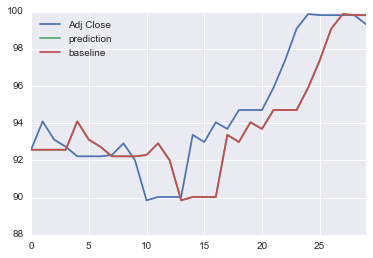

In [245]:
# Base line : return previous day's Adj close
y_baseline_df=y_test.copy().shift(prediction_days)
y_baseline_df.fillna(method='ffill', inplace='TRUE')
y_baseline_df.fillna(method='bfill', inplace='TRUE')
y_baseline=y_baseline_df["Adj Close"].tolist()
y_test_out = y_test_out.reset_index().drop("index", axis=1)

print_result("Baseline", y_test.copy(), y_baseline, y_baseline)

Lasso LARS Error : 1.92645286182%


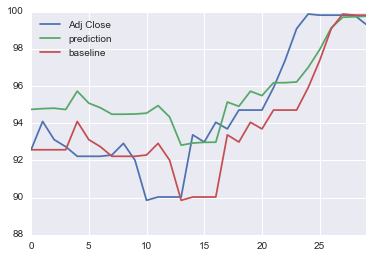

In [246]:
# Lasso LARS
from sklearn import linear_model
lasso_lars = linear_model.LassoLars(alpha = 0.1)
lasso_lars.fit(X_train, y_train["Adj Close"])
y_pred = lasso_lars.predict(X_test)
print_result("Lasso LARS", y_test, y_pred, y_baseline)

Lasso Error : 2.9784226693%


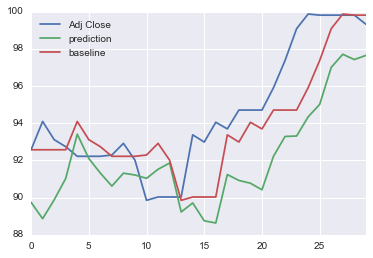

In [247]:
# Lasso
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train["Adj Close"])
y_pred = lasso.predict(X_test)
print_result("Lasso", y_test, y_pred, y_baseline)

Ridge Error : 3.27042917996%


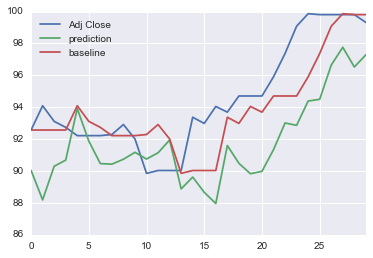

In [248]:
# Ridge
from sklearn import linear_model
ridge = linear_model.Ridge (alpha = .5)
ridge.fit(X_train, y_train["Adj Close"])
y_pred = ridge.predict(X_test)
print_result("Ridge", y_test, y_pred, y_baseline)

Bayesian Ridge Error : 2.27640959897%


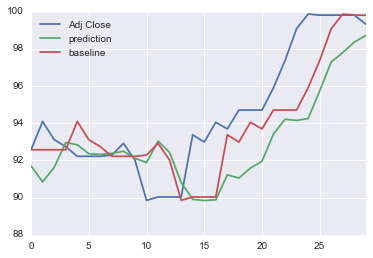

In [249]:
# Bayesian Ridge
from sklearn import linear_model
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(X_train, y_train["Adj Close"])
y_pred = bayesian_ridge.predict(X_test)
print_result("Bayesian Ridge", y_test, y_pred, y_baseline)

Gradient Boost Error : 2.3229724527%


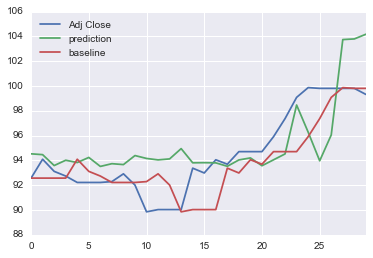

In [250]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boost=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=6, random_state=0, loss='ls')
gradient_boost.fit(X_train, y_train["Adj Close"])
y_pred = gradient_boost.predict(X_test)
print_result("Gradient Boost", y_test, y_pred, y_baseline)

Decision Tree Regression Error : 2.01552026383%


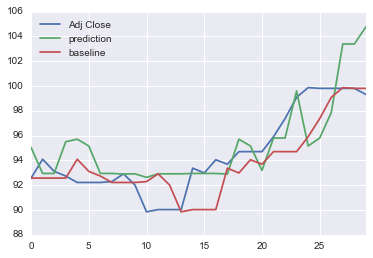

In [251]:
# Decision Tree Regression
from sklearn import tree
decision_tree = tree.DecisionTreeRegressor()
decision_tree.fit(X_train, y_train["Adj Close"])
y_pred = decision_tree.predict(X_test)
print_result("Decision Tree Regression", y_test, y_pred, y_baseline)

Random Forests Error : 3.88237781964%


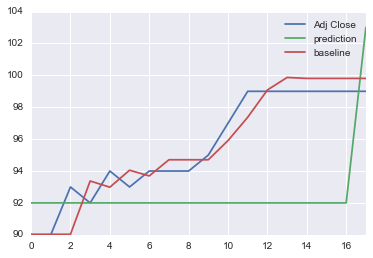

In [177]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_int_train, y_int_train["Adj Close"])
y_pred=random_forest.predict(X_int_test)
print_result("Random Forests", y_int_test, y_pred, y_baseline)

Logistic Regression Error : 3.59582434159%


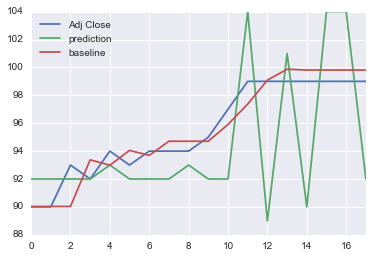

In [178]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_int_train, y_int_train["Adj Close"])
y_pred = logreg.predict(X_int_test)
print_result("Logistic Regression", y_int_test, y_pred, y_baseline)

Support Vector Machine Regression Error : 8.58578229297%


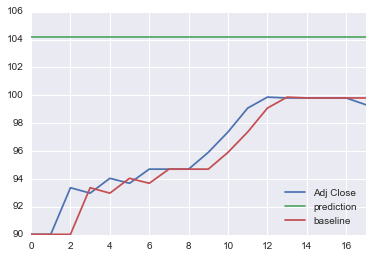

In [180]:
# Support Vector Machines
from sklearn import svm
from sklearn.svm import SVC, LinearSVC

svr = svm.SVR()
svr.fit(X_train, y_train["Adj Close"])
y_pred = svr.predict(X_test)
print_result("Support Vector Machine Regression", y_test, y_pred, y_baseline)

KNN Error : 3.82626109685%


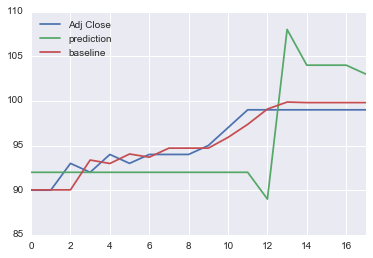

In [181]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_int_train, y_int_train["Adj Close"])
y_pred = knn.predict(X_int_test)
print_result("KNN", y_int_test, y_pred, y_baseline)

Gaussian Naive Bayes Error : 3.48956076015%


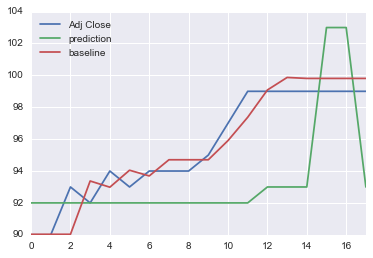

In [183]:
from sklearn.naive_bayes import GaussianNB

# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_int_train, y_int_train["Adj Close"])
y_pred = gaussian.predict(X_int_test)
print_result("Gaussian Naive Bayes", y_int_test, y_pred, y_baseline)

Ada Boost Error : 5.14607737466%


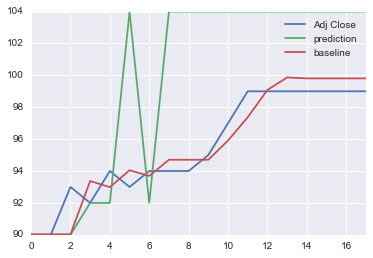

In [184]:
from sklearn.ensemble import AdaBoostClassifier

adaboost=AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_int_train, y_int_train["Adj Close"])
y_pred = adaboost.predict(X_int_test)
print_result("Ada Boost", y_int_test, y_pred, y_baseline)

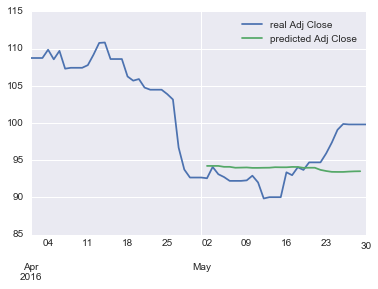

In [255]:
def predict_future_values(symbol, stocks, start_day, end_day, regressor, predict_day):
    google=Stock(symbol=symbol,stocks=stocks
                , start_date=start_day, end_date=end_day
                , momentum_window=7, sma_window=7, bollinger_bands_window=7)

    feature_days=4
    predict_day=predict_day

    X=google.get_train_df_for_prediction(feature_days=feature_days, prediction_days=predict_day) \
        .reset_index().drop("index", axis=1)
    y=google.original_df[google.max_window+prediction_days:] \
        .reset_index().drop("index", axis=1)

    data_len_limit = int(min(len(X), len(y)))
    train_len_limit = int(0.8*data_len_limit)
    
    X_train, X_test=X[:train_len_limit], X[train_len_limit:data_len_limit]
    y_train, y_test=y[:train_len_limit], y[train_len_limit:data_len_limit]
    
    regressor.fit(X_train, y_train["Adj Close"])
    y_pred = regressor.predict(X_test)
    #print_result("Ridge", y_test, y_pred)
    return regressor.predict(google.get_train_df_for_prediction(feature_days=feature_days, prediction_days=0)[-1:])
    
symbol='AAPL'
start_day='2016-01-01'
end_day='2016-05-01'

predict_days_max=28

import datetime
end_datetime = datetime.datetime.strptime(end_day, "%Y-%m-%d") + datetime.timedelta(days=1)
predict_end_datetime = end_datetime + datetime.timedelta(days=predict_days_max)
dates = pd.date_range(end_datetime.strftime("%Y-%m-%d"), predict_end_datetime.strftime("%Y-%m-%d"))

target_stock=Stock(symbol=symbol,stocks=stocks
                , start_date=start_day, end_date=predict_end_datetime.strftime("%Y-%m-%d")
                , momentum_window=3, sma_window=3, bollinger_bands_window=3)

prediction_df = target_stock.original_df.copy().rename(columns={'Adj Close': 'real Adj Close'})

for i in range(1, predict_days_max + 1):
    predict_datetime = end_datetime + datetime.timedelta(days=i-1)
    regressor=linear_model.LassoLars(alpha = 0.1)
#     regressor=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=6, random_state=0, loss='ls')
    prediction_df_index_name=predict_datetime.strftime("%Y-%m-%d")
    prediction_result=predict_future_values(symbol=symbol, stocks=stocks, start_day=start_day, end_day=end_day, regressor=regressor, predict_day=i)
    prediction_df.loc[prediction_df_index_name, 'predicted Adj Close']=prediction_result

plot_start_day = (datetime.datetime.strptime(end_day, "%Y-%m-%d") + datetime.timedelta(days=-30)).strftime("%Y-%m-%d")
prediction_df[plot_start_day:].plot()


In [17]:
# TODO refactoring recommender interface.
# TODO impl base line recommender(predict final Adj Close value)